## Importing Libraries

In [1]:
import cv2

from glob import glob
import random
import os

import pandas as pd
import numpy as np

import visualkeras
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 

from PIL import ImageFile                            

from sklearn.metrics import classification_report
from sklearn.datasets import load_files  
from keras.models import Sequential, load_model
from keras.utils import np_utils
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter('ignore')

sns.set(style="white")
%matplotlib inline

Using TensorFlow backend.


## Loading Datasets

In [2]:
def load_dataset(path):
    data = load_files(path)
    file = np.array(data['filenames'])
    target = np_utils.to_categorical(np.array(data['target']), 133)
    return file, target

In [3]:
X_train, y_train = load_dataset('dogImages/train')
X_valid, y_valid = load_dataset('dogImages/valid')
X_test, y_test = load_dataset('dogImages/test')

In [4]:
breed_names = [item[20:-1].replace('_',' ').title() for item in sorted(glob('dogImages/train/*/'))]

In [5]:
breed_names[:10]

['Affenpinscher',
 'Afghan Hound',
 'Airedale Terrier',
 'Akita',
 'Alaskan Malamute',
 'American Eskimo Dog',
 'American Foxhound',
 'American Staffordshire Terrier',
 'American Water Spaniel',
 'Anatolian Shepherd Dog']

In [6]:
print('There are %d total dog breeds.' % len(breed_names))
print('There are %s total dog images.\n' % len(np.hstack([X_train, X_valid, X_test])))
print('There are %d training dog images.' % len(X_train))
print('There are %d validation dog images.' % len(X_valid))
print('There are %d test dog images.'% len(X_test))

There are 133 total dog breeds.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [7]:
breed, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
ids = np.where(np.min(counts) == counts)[0].tolist()
breed_name = [breed_names[ids].split('.')[-1] for ids in breed]

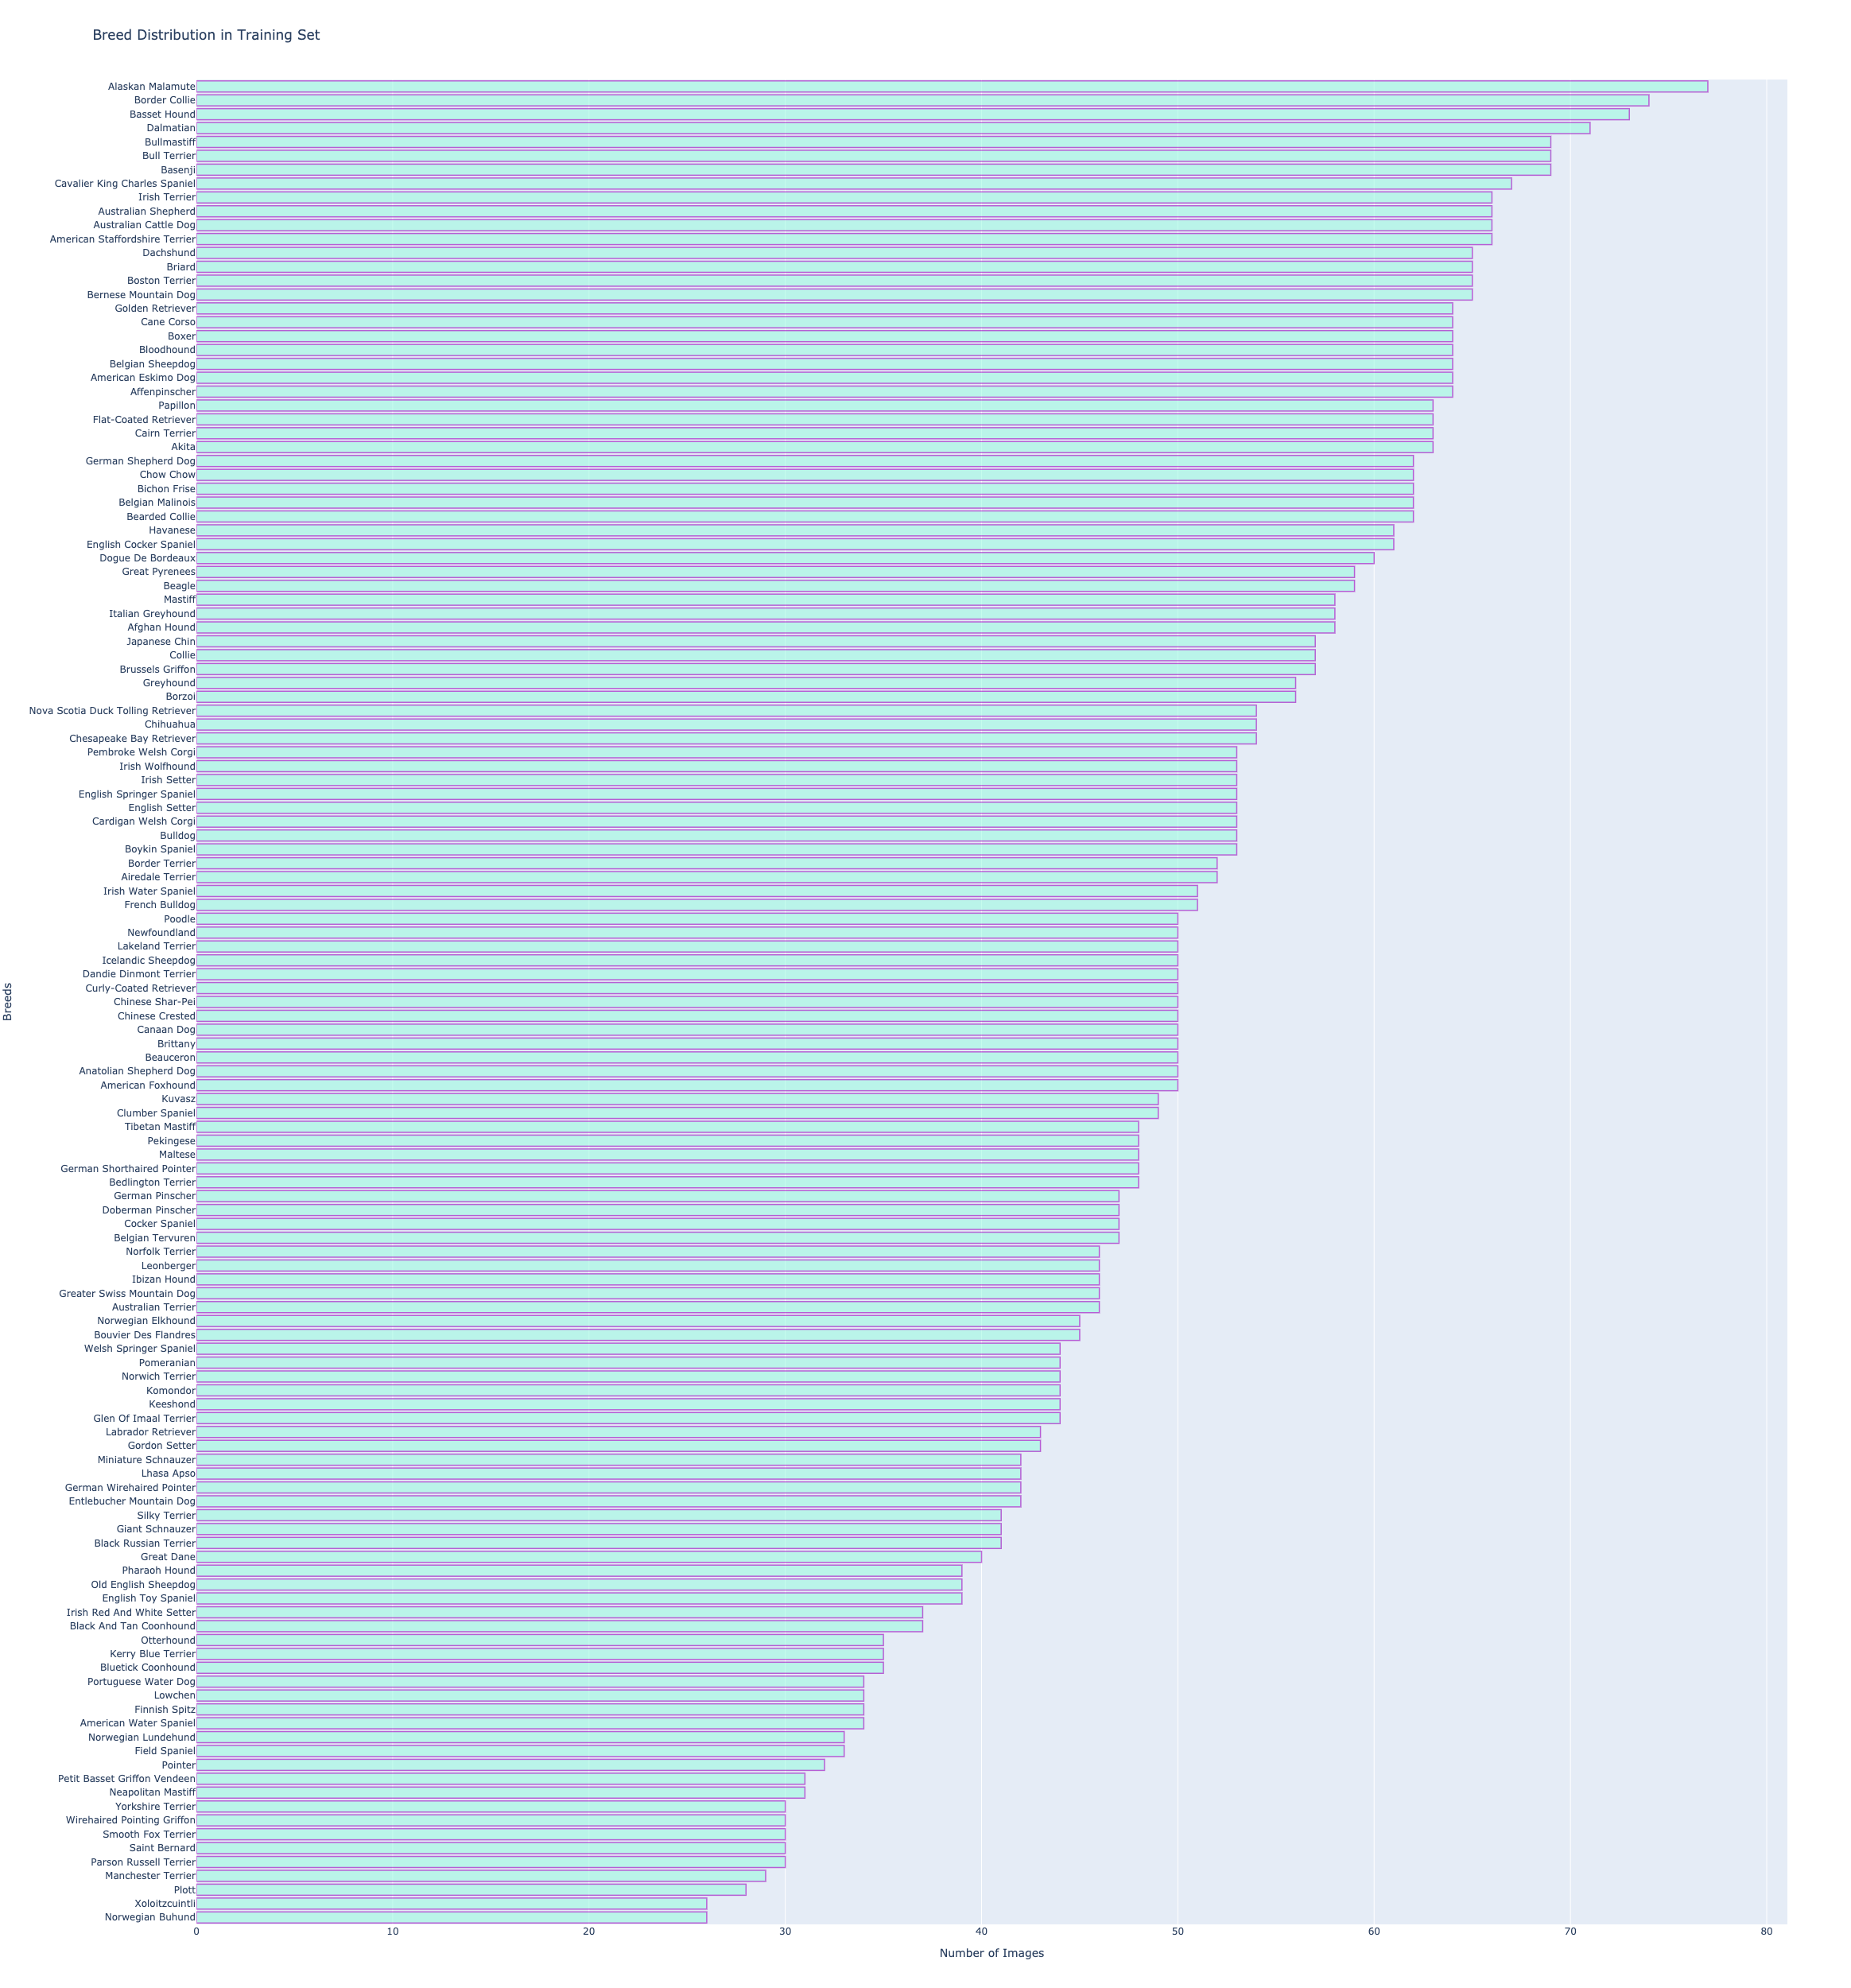

In [8]:
#Plotting the number of images per breed sorted in descending order - training set

fig = px.bar(x=counts, y=breed_name, title='Breed Distribution in Training Set', width=800, height=2500)

fig.update_xaxes(title_font_family="Arial", title='Number of Images')
fig.update_yaxes(title_font_family="Arial", title='Breeds')
fig.update_layout(showlegend=False, yaxis={'categoryorder':'total ascending'})

fig.update_traces(marker_color='rgb(158,250,225)', marker_line_color='rgb(150,0,189)',
                  marker_line_width=1.5, opacity=0.6)

fig.show();

The Alaskan Malamute has the most number of images and Norwegian Buhund/Xoloitzcuintli have the least number of images in the training set.

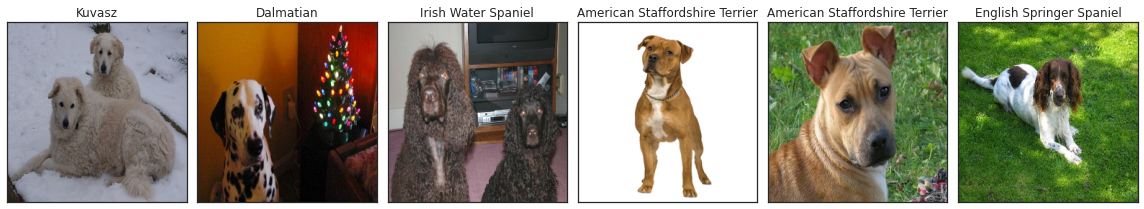

In [9]:
#Checking out a couple of dog images.

fig, axes = plt.subplots(1,6, figsize=(16,14))

for i, ax in enumerate(axes.flatten()):
    
    img = cv2.imread(X_train[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (250,250))
    label = np.argmax(y_train[i], axis=-1)
    label = breed_names[label]
    
    ax.imshow(img)
    
    ax.set_title(label)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.tight_layout()

--- 

### Dog Detection

In [10]:
ResNet50_model = ResNet50(weights='imagenet')

2021-09-03 01:05:35.571111: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2200160000 Hz
2021-09-03 01:05:35.572127: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563b48db6ea0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-09-03 01:05:35.572154: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-09-03 01:05:35.572306: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
def tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    
    x = image.img_to_array(img)
    
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def tensor_list(img_paths):
    list_of_tensors = [tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [12]:
def ResNet50_predict_labels(img_path):
    img = preprocess_input(tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [13]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

In [14]:
dogs_100 = X_train[:100]

detected_face_dog_files = 0

for i in range(100):
    if dog_detector(dogs_100[i]):
        detected_face_dog_files = detected_face_dog_files + 1

print("Percentage of dog faces detected in first 100 dog files : {}%".format(detected_face_dog_files))

Percentage of dog faces detected in first 100 dog files : 100%


---

### Data Preprocessing

In [15]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
X_train_tensors = tensor_list(X_train).astype('float32')/255
X_valid_tensors = tensor_list(X_valid).astype('float32')/255
X_test_tensors = tensor_list(X_test).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 126.63it/s]


---- 

### Baseline Modeling

In [16]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(2), activation='relu', input_shape=( 224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 20), strides=(2, 2)))

model.add(Conv2D(16, kernel_size=(2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 20), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size=(2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 20), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 10), strides=(2, 2)))

model.add(GlobalAveragePooling2D())

model.add(Dense(133, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 102, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 101, 16)      1040      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 41, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 55, 41, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 40, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 11, 32)        0

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [18]:
checkpoint = ModelCheckpoint(filepath='saved_models/baseline_model', 
                               verbose=1, save_best_only=True)

In [19]:
model.fit(X_train_tensors, 
          y_train, 
          validation_data=(X_valid_tensors, y_valid),
          epochs=10,
          callbacks=[checkpoint]
         )

Epoch 1/10
209/209 [==============================] - ETA: 0s - loss: 4.8854 - accuracy: 0.0090
Epoch 00001: val_loss improved from inf to 4.88118, saving model to saved_models/baseline_model
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2021-09-03 01:08:36.454342: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_models/baseline_model/assets
209/209 [==============================] - 69s 328ms/step - loss: 4.8854 - accuracy: 0.0090 - val_loss: 4.8812 - val_accuracy: 0.0108
Epoch 2/10
209/209 [==============================] - ETA: 0s - loss: 4.8715 - accuracy: 0.0099
Epoch 00002: val_loss improved from 4.88118 to 4.87766, saving model to saved_models/baseline_model
INFO:tensorflow:Assets written to: saved_models/baseline_model/assets
209/209 [==============================] - 68s 324ms/step - loss: 4.8715 - accuracy: 0.0099 - val_loss: 4.8777 - val_accuracy: 0.0108
Epoch 3/10
209/209 [==============================] - ETA: 0s - loss: 4.8665 - accuracy: 0.0102
Epoch 00003: val_loss improved from 4.87766 to 4.86900, saving model to saved_models/baseline_model
INFO:tensorflow:Assets written to: saved_models/baseline_model/assets
209/209 [==============================] - 66s 315ms/step - loss: 4.8665 - accuracy: 0.0102 - val_loss: 4.8690 - val_accuracy: 0.0

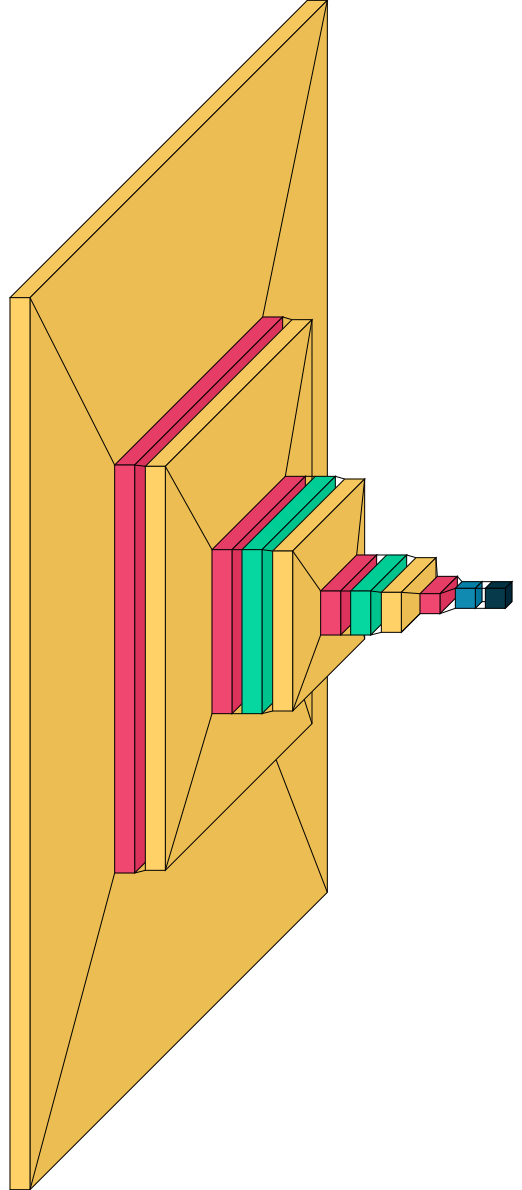

In [20]:
visualkeras.layered_view(model, scale_xy=100, scale_z=100,legend=True)
visualkeras.layered_view(model, to_file='output.png') # write to disk

In [21]:
model.save('saved_models/baseline_model')
model = load_model('saved_models/baseline_model')

INFO:tensorflow:Assets written to: saved_models/baseline_model/assets


In [22]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in X_test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(y_test, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 3.9474%


---

### Transfer Learning

##### ResNet50

In [23]:
bottleneck_features = np.load('DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

In [24]:
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(64, kernel_regularizer=l2(0.01)))
Resnet50_model.add(Dropout(0.3))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                131136    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               8645      
Total params: 139,781
Trainable params: 139,781
Non-trainable params: 0
_________________________________________________________________


In [25]:
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
checkpoint = ModelCheckpoint(filepath='saved_models/Resnet50_model', 
                               verbose=1, save_best_only=True)

In [27]:
model_training_ResNet50 = Resnet50_model.fit(train_Resnet50, y_train, 
          validation_data=(valid_Resnet50, y_valid),
          epochs=20, callbacks=[checkpoint], verbose=1)

Epoch 1/20
198/209 [===========================>..] - ETA: 0s - loss: 3.7845 - accuracy: 0.3729
Epoch 00001: val_loss improved from inf to 2.11494, saving model to saved_models/Resnet50_model
INFO:tensorflow:Assets written to: saved_models/Resnet50_model/assets
209/209 [==============================] - 3s 16ms/step - loss: 3.7262 - accuracy: 0.3795 - val_loss: 2.1149 - val_accuracy: 0.6719
Epoch 2/20
196/209 [===========================>..] - ETA: 0s - loss: 1.9085 - accuracy: 0.6765
Epoch 00002: val_loss improved from 2.11494 to 1.50421, saving model to saved_models/Resnet50_model
INFO:tensorflow:Assets written to: saved_models/Resnet50_model/assets
209/209 [==============================] - 3s 16ms/step - loss: 1.9009 - accuracy: 0.6751 - val_loss: 1.5042 - val_accuracy: 0.7665
Epoch 3/20
207/209 [============================>.] - ETA: 0s - loss: 1.4457 - accuracy: 0.7529
Epoch 00003: val_loss improved from 1.50421 to 1.30234, saving model to saved_models/Resnet50_model
INFO:tensorf

In [28]:
model.save('saved_models/ResNet50_model')
model = load_model('saved_models/ResNet50_model')

INFO:tensorflow:Assets written to: saved_models/ResNet50_model/assets


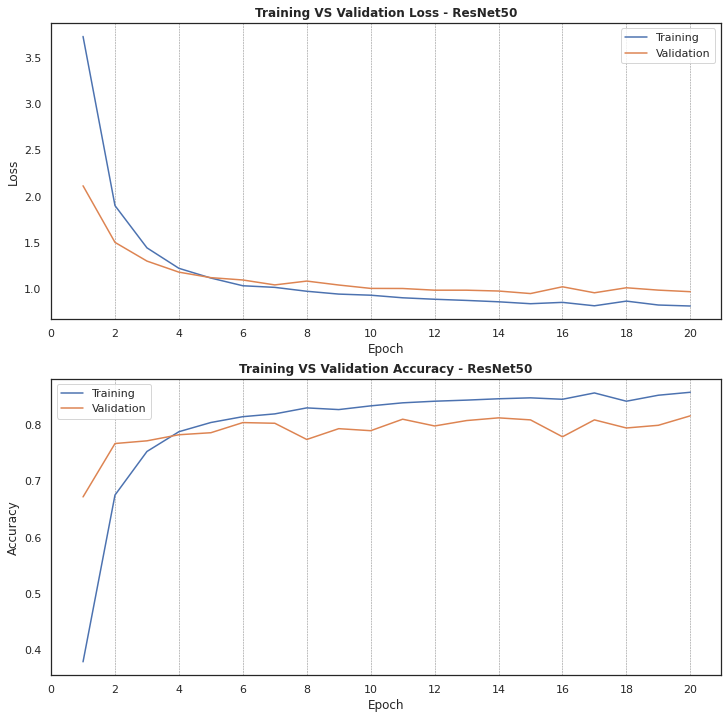

In [29]:
# Training vs Validation Loss AND Training vs Validation Accuracy PLOTS - VGG16 MODEL

fig, axes = plt.subplots(2, 1, figsize = (12, 12))

# Training vs Validation Loss
axes[0].plot(range(1, 21), model_training_ResNet50.history['loss'])
axes[0].plot(range(1, 21), model_training_ResNet50.history['val_loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title(f'Training VS Validation Loss - ResNet50', fontweight ="bold")
axes[0].set_xticks(list(range(0,21,2)))
axes[0].legend(['Training', 'Validation'])
axes[0].grid(color='grey', linestyle='--', linewidth=0.5, axis='x')

# Training vs Accuracy
axes[1].plot(range(1, 21), model_training_ResNet50.history['accuracy'])
axes[1].plot(range(1, 21), model_training_ResNet50.history['val_accuracy'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title(f'Training VS Validation Accuracy - ResNet50', fontweight ="bold")
axes[1].set_xticks(list(range(0,21,2)))
axes[1].legend(['Training', 'Validation'])
axes[1].grid(color='grey', linestyle='--', linewidth=0.5, axis='x')

# Save the graphs
fig.savefig('ResNet50', dpi=300, bbox_inches='tight')

In [30]:
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(y_test, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.0239%


In [31]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.array(Resnet50_predictions)

print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.875     0.933         8
           1      1.000     1.000     1.000         8
           2      0.800     0.667     0.727         6
           3      1.000     0.875     0.933         8
           4      0.833     1.000     0.909        10
           5      1.000     0.750     0.857         8
           6      0.750     0.857     0.800         7
           7      0.889     1.000     0.941         8
           8      1.000     0.250     0.400         4
           9      1.000     0.833     0.909         6
          10      1.000     0.556     0.714         9
          11      0.857     0.667     0.750         9
          12      1.000     0.500     0.667         6
          13      0.692     1.000     0.818         9
          14      0.900     0.900     0.900        10
          15      0.889     1.000     0.941         8
          16      0.727     1.000     0.842         8
          17      0.750    

--- 

##### VGG16

In [32]:
bottleneck_features = np.load('DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [33]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(64,kernel_regularizer=l2(0.1)))

VGG16_model.add(Dropout(0.3))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               8645      
Total params: 41,477
Trainable params: 41,477
Non-trainable params: 0
_________________________________________________________________


In [34]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
checkpoint = ModelCheckpoint(filepath='saved_models/VGG16_model', 
                               verbose=1, save_best_only=True)

model_training_VGG16 = VGG16_model.fit(train_VGG16, y_train, 
                                       validation_data=(valid_VGG16, y_valid),
                                       epochs=20,
                                       callbacks=[checkpoint]
                                      )

Epoch 1/20
207/209 [============================>.] - ETA: 0s - loss: 16.4237 - accuracy: 0.1313
Epoch 00001: val_loss improved from inf to 7.63401, saving model to saved_models/VGG16_model
INFO:tensorflow:Assets written to: saved_models/VGG16_model/assets
209/209 [==============================] - 2s 8ms/step - loss: 16.3630 - accuracy: 0.1323 - val_loss: 7.6340 - val_accuracy: 0.4144
Epoch 2/20
203/209 [============================>.] - ETA: 0s - loss: 6.3637 - accuracy: 0.4210
Epoch 00002: val_loss improved from 7.63401 to 4.14771, saving model to saved_models/VGG16_model
INFO:tensorflow:Assets written to: saved_models/VGG16_model/assets
209/209 [==============================] - 1s 7ms/step - loss: 6.3302 - accuracy: 0.4217 - val_loss: 4.1477 - val_accuracy: 0.5964
Epoch 3/20
207/209 [============================>.] - ETA: 0s - loss: 3.6849 - accuracy: 0.5643
Epoch 00003: val_loss improved from 4.14771 to 2.65119, saving model to saved_models/VGG16_model
INFO:tensorflow:Assets writ

In [36]:
VGG16_model.save('saved_models/VGG16_model')
model = load_model('saved_models/VGG16_model')

INFO:tensorflow:Assets written to: saved_models/VGG16_model/assets


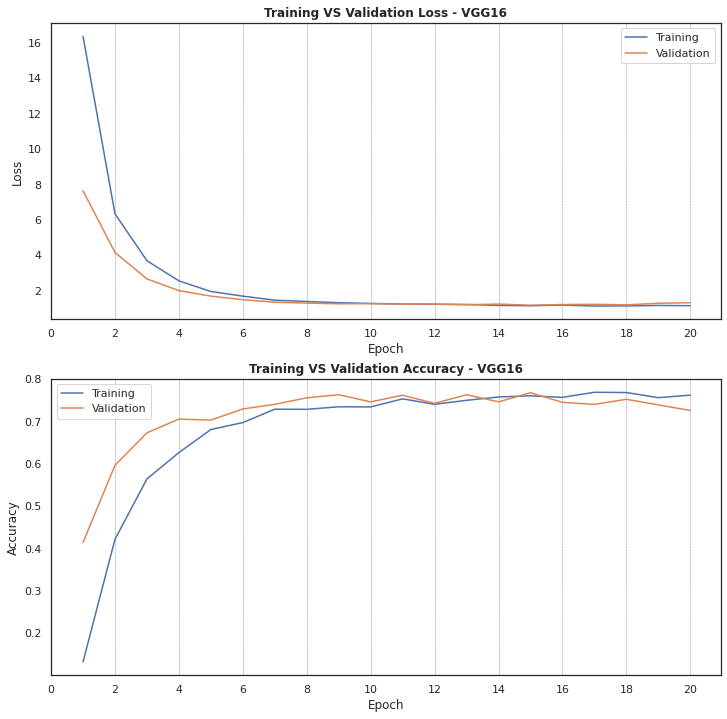

In [37]:
# Training vs Validation Loss AND Training vs Validation Accuracy PLOTS - VGG16 MODEL

fig, axes = plt.subplots(2, 1, figsize = (12, 12))

# Training vs Validation Loss
axes[0].plot(range(1, 21), model_training_VGG16.history['loss'])
axes[0].plot(range(1, 21), model_training_VGG16.history['val_loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title(f'Training VS Validation Loss - VGG16', fontweight ="bold")
axes[0].set_xticks(list(range(0,21,2)))
axes[0].legend(['Training', 'Validation'])
axes[0].grid(color='grey', linestyle='--', linewidth=0.5, axis='x')

# Training vs Accuracy
axes[1].plot(range(1, 21), model_training_VGG16.history['accuracy'])
axes[1].plot(range(1, 21), model_training_VGG16.history['val_accuracy'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title(f'Training VS Validation Accuracy - VGG16', fontweight ="bold")
axes[1].set_xticks(list(range(0,21,2)))
axes[1].legend(['Training', 'Validation'])
axes[1].grid(color='grey', linestyle='--', linewidth=0.5, axis='x')

# Save the graphs
fig.savefig('VGG16.png', dpi=300, bbox_inches='tight')

In [38]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(y_test, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 73.0861%


In [39]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.array(VGG16_predictions)

print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.375     0.545         8
           1      1.000     0.875     0.933         8
           2      0.833     0.833     0.833         6
           3      1.000     0.625     0.769         8
           4      0.833     1.000     0.909        10
           5      1.000     0.875     0.933         8
           6      0.667     0.857     0.750         7
           7      1.000     0.875     0.933         8
           8      1.000     0.500     0.667         4
           9      0.571     0.667     0.615         6
          10      1.000     0.556     0.714         9
          11      1.000     0.889     0.941         9
          12      0.750     1.000     0.857         6
          13      1.000     0.889     0.941         9
          14      1.000     0.900     0.947        10
          15      1.000     0.500     0.667         8
          16      0.636     0.875     0.737         8
          17      0.800    

--- 

##### InceptionV3

In [40]:
bottleneck_features = np.load('DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

In [41]:
InceptionV3_model = Sequential()

# Adding the Pooling and Dropout layer to reduce complexity and prevent overfitting
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dense(64,kernel_regularizer=l2(0.01)))
InceptionV3_model.add(Dropout(0.25))

# Activation function, this time applying a softmax approach
InceptionV3_model.add(Dense(133, activation='softmax'))

InceptionV3_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                131136    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               8645      
Total params: 139,781
Trainable params: 139,781
Non-trainable params: 0
_________________________________________________________________


In [42]:
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
checkpoint = ModelCheckpoint(filepath='saved_models/InceptionV3_model', 
                               verbose=1, save_best_only=True)

model_training_InceptionV3 = InceptionV3_model.fit(train_InceptionV3,y_train, 
                                                   validation_data=(valid_InceptionV3, y_valid), 
                                                   epochs=20, 
                                                   callbacks=[checkpoint]
                                                  )

Epoch 1/20
209/209 [==============================] - ETA: 0s - loss: 2.9465 - accuracy: 0.5913
Epoch 00001: val_loss improved from inf to 1.68321, saving model to saved_models/InceptionV3_model
INFO:tensorflow:Assets written to: saved_models/InceptionV3_model/assets
209/209 [==============================] - 7s 34ms/step - loss: 2.9465 - accuracy: 0.5913 - val_loss: 1.6832 - val_accuracy: 0.7940
Epoch 2/20
209/209 [==============================] - ETA: 0s - loss: 1.5489 - accuracy: 0.7799
Epoch 00002: val_loss improved from 1.68321 to 1.25929, saving model to saved_models/InceptionV3_model
INFO:tensorflow:Assets written to: saved_models/InceptionV3_model/assets
209/209 [==============================] - 6s 28ms/step - loss: 1.5489 - accuracy: 0.7799 - val_loss: 1.2593 - val_accuracy: 0.8120
Epoch 3/20
208/209 [============================>.] - ETA: 0s - loss: 1.2223 - accuracy: 0.8054
Epoch 00003: val_loss improved from 1.25929 to 1.07300, saving model to saved_models/InceptionV3_mod

In [44]:
InceptionV3_model.save('saved_models/InceptionV3_model')
model = load_model('saved_models/InceptionV3_model')

INFO:tensorflow:Assets written to: saved_models/InceptionV3_model/assets


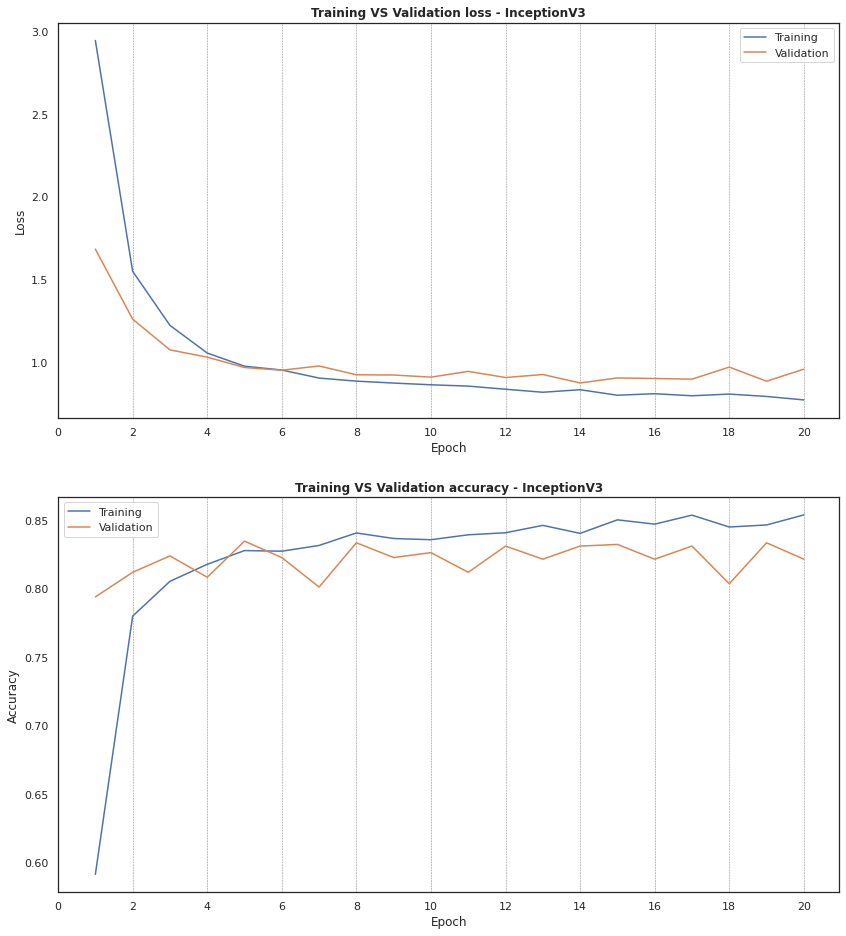

In [45]:
#Training vs Validation Loss AND Training vs Validation Accuracy PLOTS - InceptionV3 MODEL

fig, axes = plt.subplots(2, 1, figsize = (14, 16))

# Training vs Validation Loss
axes[0].plot(range(1, 21), model_training_InceptionV3.history['loss'])
axes[0].plot(range(1, 21), model_training_InceptionV3.history['val_loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title(f'Training VS Validation loss - InceptionV3',fontweight ="bold")
axes[0].set_xticks(list(range(0,21,2)))
axes[0].legend(['Training', 'Validation'])
axes[0].grid(color='grey', linestyle='--', linewidth=0.5, axis='x')

# Training vs Accuracy
axes[1].plot(range(1, 21), model_training_InceptionV3.history['accuracy'])
axes[1].plot(range(1, 21), model_training_InceptionV3.history['val_accuracy'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title(f'Training VS Validation accuracy - InceptionV3', fontweight ="bold")
axes[1].set_xticks(list(range(0,21,2)))
axes[1].legend(['Training', 'Validation'])
axes[1].grid(color='grey', linestyle='--', linewidth=0.5, axis='x')

# Save the graphs
fig.savefig('InceptionV3.png', dpi=300, bbox_inches='tight')

In [46]:
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(InceptionV3_predictions)==np.argmax(y_test, axis=1))/len(InceptionV3_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.1866%


In [47]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.array(InceptionV3_predictions)

print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.750     0.857         8
           1      1.000     0.750     0.857         8
           2      1.000     0.833     0.909         6
           3      1.000     0.875     0.933         8
           4      0.769     1.000     0.870        10
           5      1.000     0.875     0.933         8
           6      1.000     0.857     0.923         7
           7      1.000     1.000     1.000         8
           8      0.667     1.000     0.800         4
           9      1.000     0.833     0.909         6
          10      0.900     1.000     0.947         9
          11      1.000     0.778     0.875         9
          12      0.625     0.833     0.714         6
          13      1.000     0.889     0.941         9
          14      0.833     1.000     0.909        10
          15      0.875     0.875     0.875         8
          16      0.750     0.750     0.750         8
          17      0.750    

InceptionV3 gave us the best test accuracy score.

--- 

In [48]:
def extract_InceptionV3(x):
    from keras.applications.inception_v3 import InceptionV3, preprocess_input
    return InceptionV3(weights='imagenet', include_top=False).predict(preprocess_input(x))

def predict_breed(img_path):
    img = cv2.imread(img_path)
    cv_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_color)
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(tensor(img_path))
    # obtain predicted vector
    predicted_vector = InceptionV3_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return breed_names[np.argmax(predicted_vector)]

'Border Collie'

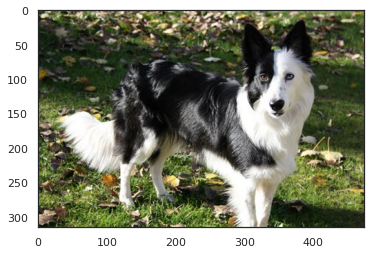

In [49]:
predict_breed('images/bordercollie.jpg')

'Australian Shepherd'

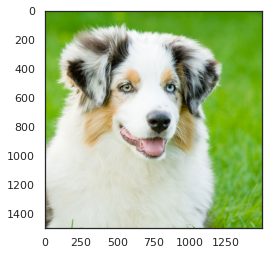

In [50]:
predict_breed('images/australianshepherd.jpg')

'Golden Retriever'

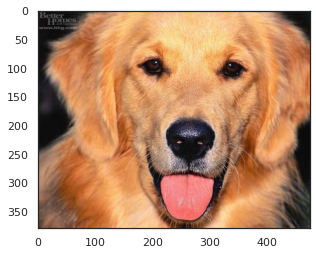

In [51]:
predict_breed('images/goldenretrievers.jpg')

'Alaskan Malamute'

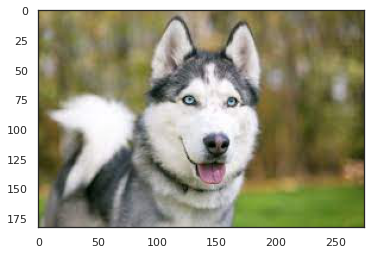

In [52]:
predict_breed('images/husky.jpg')

'Akita'

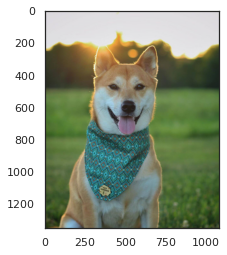

In [53]:
predict_breed('images/shibainu.jpg')

'Affenpinscher'

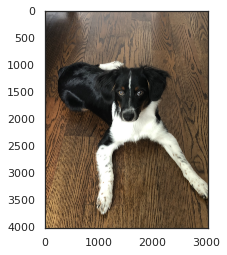

In [54]:
predict_breed('images/frankie.jpeg')